# 椭圆轨道

In [3]:
import torch
import torchvision
import numpy as np
import importlib
from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams
from gaussian_renderer import render
from scene import Scene, GaussianModel
import tqdm as notebook_tqdm

In [25]:
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--save_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(["-s", "data/kitchen_8", "-m", "output/kitchen_8"])
dataset = lp.extract(args)
opt = op.extract(args)
pipe = pp.extract(args)

In [26]:
gaussians = GaussianModel(dataset.sh_degree, opt.optimizer_type)
scene = Scene(dataset, gaussians)

Reading camera 8/8
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  22


In [27]:
views = scene.getTrainCameras()

In [28]:
poses = []
for view in views:
    pose = np.eye(4)
    pose[:3] = np.concatenate([view.R.T, view.T[:, None]], 1)
    pose = np.linalg.inv(pose)
    pose[:, 1:3] *= -1
    poses.append(pose)

# 伪视图生成

In [1]:
import torch
import torchvision
import numpy as np
import importlib
from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams
from gaussian_renderer import render
from scene import Scene, GaussianModel
import tqdm as notebook_tqdm

In [2]:
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--save_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(["-s", "data/bicycle_2", "-m", "output3/bicycle_2"])
dataset = lp.extract(args)
opt = op.extract(args)
pipe = pp.extract(args)

In [51]:
gaussians = GaussianModel(dataset.sh_degree, opt.optimizer_type)
scene = Scene(dataset, gaussians)

Reading camera 2/2
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  170618


In [52]:
ori_views = scene.getTrainCameras()

In [20]:
from scipy.spatial.transform import Rotation as R
R1 = R.from_quat(np.array([0.8395176994653495, -0.00012065300298831745, 0.5433144542162123, -0.004406990696602375])).as_matrix()  # (3,3)
R2 = R.from_quat(np.array([0.0, 0.0, 0.0, 1])).as_matrix()  # (3,3)

In [53]:
ori_views[0].R

array([[ 0.40957996, -0.0075306 , -0.91224314],
       [ 0.00726839,  0.99996113, -0.00499134],
       [ 0.91224526, -0.00458618,  0.40961878]])

In [93]:
def get_new_pose(original_pose, num_views=14):
    R1 = original_pose[0].R # (3,3)
    R2 = original_pose[1].R  # (3,3)
    t1 =  original_pose[0].T
    t2 =  original_pose[1].T
    C1 = -R1.T @ t1  # (3,1)
    C2 = -R2.T @ t2  # (3,1)
    center = (C1 + C2) / 2  # 椭圆中心 (3,1)
    a = np.linalg.norm(C1 - C2) / 2  # 长轴
    b = a / 2  # 短轴

    # 计算两个相机视角之间的角度范围
    angle1 = np.arctan2(C1[1] - center[1], C1[0] - center[0])  # 视角1的角度
    angle2 = np.arctan2(C2[1] - center[1], C2[0] - center[0])  # 视角2的角度

    # 确保角度按顺时针或逆时针顺序排列
    if angle2 < angle1:
        angle2 += 2 * np.pi  # 保证 angle2 大于 angle1

    # 在两个视角之间均匀分布的角度
    angles = np.linspace(angle1, angle2, num_views)  # 均匀采样角度

    # 生成椭圆轨道上的点
    ellipse_points = np.hstack([a * np.cos(angles).reshape(-1, 1),
                                b * np.sin(angles).reshape(-1, 1),
                                np.zeros((num_views, 1))])  # (num_views, 3)

    # 处理广播问题 (转换 center 为 (1,3) 以进行广播)
    center = center.reshape(1, 3)  # 确保形状匹配
    ellipse_points = ellipse_points + center  # (num_views, 3) + (1, 3) 可广播

    # 计算每个点的位姿
    poses = []
    for point in ellipse_points:
        # 相机位置
        C_new = point.reshape(3, 1)  # 转换为 (3,1)

        # 相机朝向场景中心
        look_at = center.T  # 变成 (3,1)
        forward = look_at - C_new
        forward = forward / np.linalg.norm(forward)

        # 计算旋转矩阵
        up = np.array([0, 1, 0])  # 假设上方向为 Y 轴
        right = np.cross(up, forward.squeeze())  # 计算右方向
        right = right / np.linalg.norm(right)
        up = np.cross(forward.squeeze(), right)  # 重新计算 up

        R_new = np.vstack((right, up, -forward.squeeze())).T  # 计算新的旋转矩阵
        # 强制保证旋转矩阵是右手坐标系
        if np.linalg.det(R_new) < 0:
            R_new = -R_new

        # 计算新的平移向量
        t_new = -R_new @ C_new

        # 将旋转矩阵和平移向量合并为一个 (3, 4) 的矩阵
        pose_new = np.hstack([R_new, t_new])  # (3, 4)

        # 添加新位姿到 poses 列表中
        poses.append(pose_new)

    # 将第一个和最后一个视角添加为原始位姿
    # R1_t = np.hstack([R1, t1])  # (3, 4)
    # R2_t = np.hstack([R2, t2])  # (3, 4)

    # poses.insert(0, R1_t)  # 在最前面添加原始第一个相机位姿
    # poses.append(R2_t)  # 在最后添加原始第二个相机位姿

    poses_np = np.array(poses, dtype=np.float32)  
    return poses_np

In [94]:
render_poses = get_new_pose(ori_views)

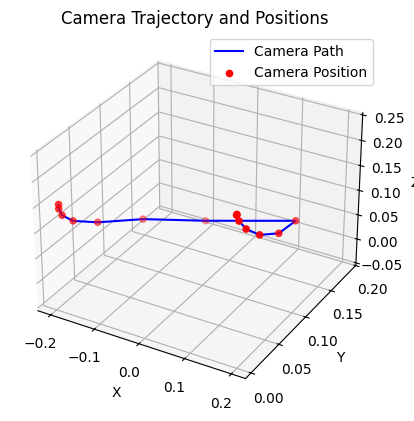

In [97]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 提取相机的轨迹（即平移向量 t_new）
trajectories = render_poses[:, :, 3]  # 取每个位姿的平移向量 (t_new)

# 提取 X, Y, Z 坐标
X = trajectories[:, 0]
Y = trajectories[:, 1]
Z = trajectories[:, 2]

# 绘制相机轨迹
ax.plot(X, Y, Z, label='Camera Path', color='blue')

# 绘制相机位置
ax.scatter(X, Y, Z, color='red', label='Camera Position')

# 添加标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 设置图形标题
ax.set_title('Camera Trajectory and Positions')

# 显示图例
ax.legend()

# 显示图形
plt.show()

In [106]:
import os, glob
def get_filelist(data_dir, postfixes):
    patterns = [os.path.join(data_dir, f"*.{postfix}") for postfix in postfixes]
    file_list = []
    for pattern in patterns:
        file_list.extend(glob.glob(pattern))
    file_list.sort()
    return file_list

In [107]:
print(get_filelist("data1/bicycle",["JPG", "png"]))

['data1/bicycle\\bicycle_01.JPG', 'data1/bicycle\\bicycle_02.png', 'data1/bicycle\\bicycle_03.png', 'data1/bicycle\\bicycle_04.png', 'data1/bicycle\\bicycle_06.png', 'data1/bicycle\\bicycle_07.JPG']


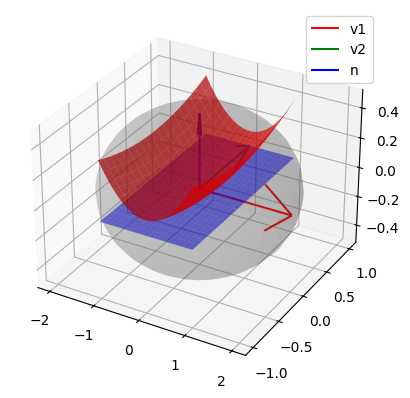

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 生成高斯椭球
theta = np.linspace(0, 2*np.pi, 30)
phi = np.linspace(0, np.pi, 30)
x = 2 * np.outer(np.cos(theta), np.sin(phi))
y = 1 * np.outer(np.sin(theta), np.sin(phi))
z = 0.5 * np.outer(np.ones(30), np.cos(phi))

# 切平面与二次曲面
u = np.linspace(-1, 1, 20)
v = np.linspace(-1, 1, 20)
X, Y = np.meshgrid(u, v)
Z_plane = 0*X + 0*Y  # 切平面
Z_quad = 0.3*X**2 + 0.1*Y**2  # 二次曲面

# 绘制
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, alpha=0.2, color='gray')  # 椭球
ax.plot_surface(X, Y, Z_plane, alpha=0.5, color='blue')  # 切平面
ax.plot_surface(X, Y, Z_quad, alpha=0.7, color='red')  # 拟合曲面

# 标注轴
ax.quiver(0,0,0, 2,0,0, color='r', label='v1')  # 主轴
ax.quiver(0,0,0, 0,1,0, color='g', label='v2')
ax.quiver(0,0,0, 0,0,0.5, color='b', label='n')
plt.legend()
plt.show()

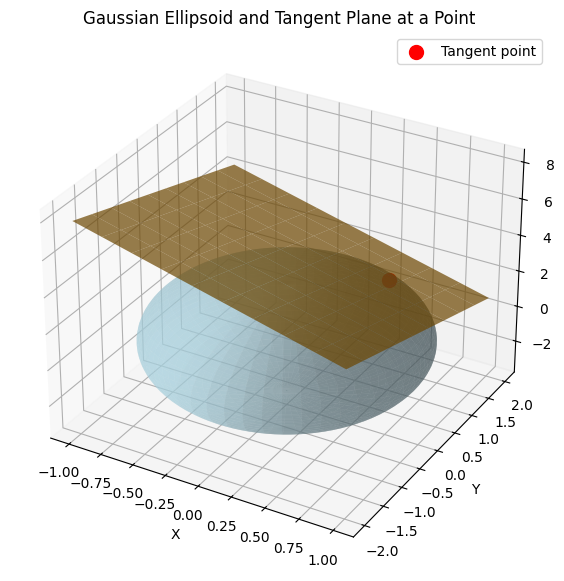

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 生成一个三维高斯椭球的函数
def gaussian_ellipsoid(a, b, c, u, v):
    """
    Generate points on a 3D Gaussian ellipsoid.
    
    :param a, b, c: The radii along x, y, z axis respectively.
    :param u, v: Parametric coordinates for spherical parameterization.
    :return: Points on the ellipsoid surface.
    """
    x = a * np.sin(u) * np.cos(v)
    y = b * np.sin(u) * np.sin(v)
    z = c * np.cos(u)
    return x, y, z

# 计算切平面
def tangent_plane_at_point(x0, y0, z0, a, b, c):
    """
    Compute the tangent plane at a given point on the ellipsoid.
    
    :param x0, y0, z0: The point on the ellipsoid.
    :param a, b, c: The radii of the ellipsoid.
    :return: Equation of the tangent plane.
    """
    # Ellipsoid equation: (x^2/a^2 + y^2/b^2 + z^2/c^2 = 1)
    # The gradient gives the normal to the surface at the point.
    normal = np.array([2 * x0 / a**2, 2 * y0 / b**2, 2 * z0 / c**2])
    d = -np.dot(normal, np.array([x0, y0, z0]))  # Plane equation: ax + by + cz + d = 0
    return normal, d

# 创建参数 u, v
u = np.linspace(0, np.pi, 100)
v = np.linspace(0, 2 * np.pi, 100)
u, v = np.meshgrid(u, v)

# 椭球的半轴长度
a, b, c = 1, 2, 3

# 获取椭球的表面点
x, y, z = gaussian_ellipsoid(a, b, c, u, v)

# 选择椭球上的一点
x0, y0, z0 = 0.5, 1.0, 2.5

# 计算该点的切平面
normal, d = tangent_plane_at_point(x0, y0, z0, a, b, c)

# 生成切平面的网格
xx, yy = np.meshgrid(np.linspace(-a, a, 10), np.linspace(-b, b, 10))
zz = (-normal[0] * xx - normal[1] * yy - d) / normal[2]

# 绘图
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 绘制椭球
ax.plot_surface(x, y, z, color='lightblue', alpha=0.5)

# 绘制切平面
ax.plot_surface(xx, yy, zz, color='orange', alpha=0.7)

# 绘制切平面点
ax.scatter(x0, y0, z0, color='red', s=100, label='Tangent point')

# 设置图形标题
ax.set_title('Gaussian Ellipsoid and Tangent Plane at a Point')

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图例
ax.legend()

plt.show()


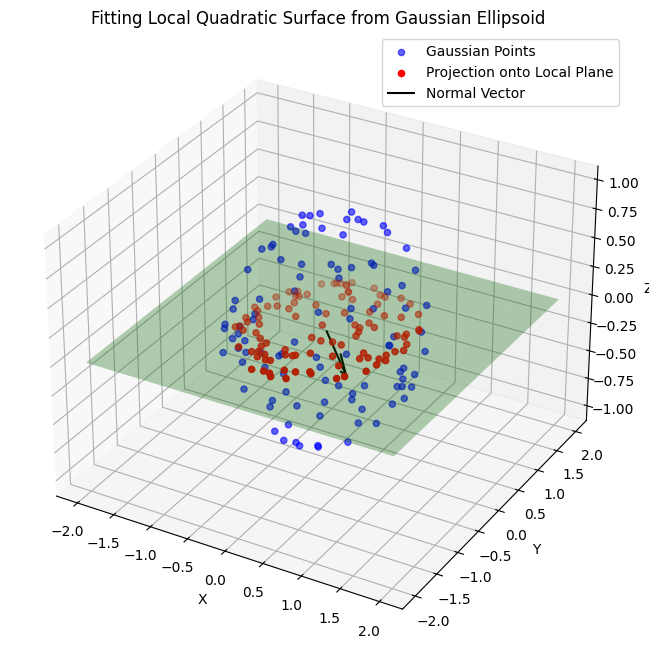

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import eigh

# 生成3D高斯椭球
def generate_gaussian_ellipsoid(center, cov_matrix, num_points=100):
    # 生成椭球的点
    eigvals, eigvecs = eigh(cov_matrix)
    eigvals = np.sqrt(eigvals)
    
    points = np.random.randn(num_points, 3)
    points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]  # 单位化
    points = points @ np.diag(eigvals) @ eigvecs.T  # 扩展为椭球形状
    points += center  # 加上中心位置
    return points

# 在局部切平面上拟合二次曲面
def fit_local_quadratic_surface(points, p_i):
    # 计算局部切平面的法向量（取高斯协方差矩阵的最小特征值对应的特征向量）
    cov_matrix = np.cov(points.T)
    eigvals, eigvecs = eigh(cov_matrix)
    normal = eigvecs[:, 0]  # 法向量（最小特征值对应的特征向量）

    # 计算局部切平面坐标
    t1 = eigvecs[:, 1]  # 正交切向量1
    t2 = eigvecs[:, 2]  # 正交切向量2

    # 计算投影
    u = (points - p_i) @ np.array([t1, t2]).T
    return u, normal, t1, t2

# 生成高斯椭球及拟合
center = np.array([0, 0, 0])
cov_matrix = np.array([[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]])  # 协方差矩阵
points = generate_gaussian_ellipsoid(center, cov_matrix)

p_i = center  # 高斯分布中心

# 获取拟合曲面的局部坐标系和投影
u, normal, t1, t2 = fit_local_quadratic_surface(points, p_i)

# 可视化
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制高斯椭球的点
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b', label='Gaussian Points', alpha=0.6)

# 绘制切平面上的投影点
ax.scatter(u[:, 0], u[:, 1], np.zeros_like(u[:, 0]), color='r', label='Projection onto Local Plane')

# 绘制局部切平面（在此示意性地绘制一个平面）
xx, yy = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
zz = np.zeros_like(xx)

# 假设拟合的二次曲面为平面（此处仅为示意，实际应用中应根据拟合结果计算）
ax.plot_surface(xx, yy, zz, color='g', alpha=0.3)

# 绘制法向量
ax.quiver(p_i[0], p_i[1], p_i[2], normal[0], normal[1], normal[2], length=1, color='black', label='Normal Vector')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Fitting Local Quadratic Surface from Gaussian Ellipsoid')
ax.legend()

plt.show()


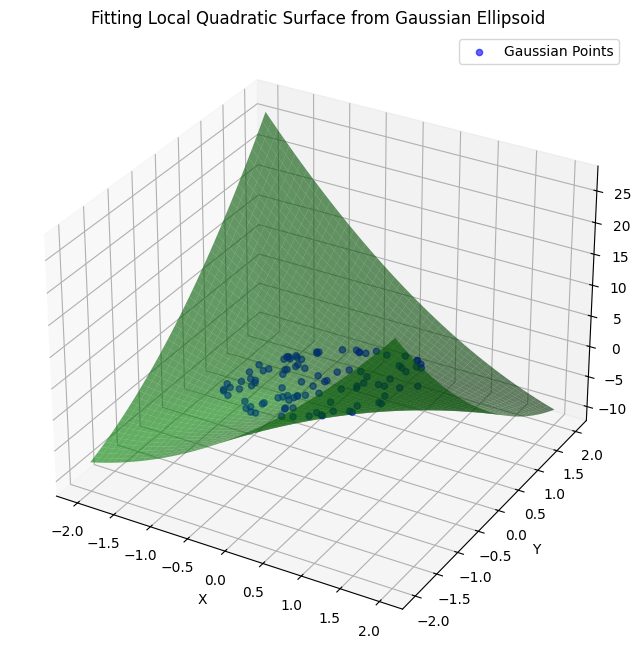

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import eigh
from scipy.optimize import least_squares

# 生成3D高斯椭球
def generate_gaussian_ellipsoid(center, cov_matrix, num_points=100):
    eigvals, eigvecs = eigh(cov_matrix)
    eigvals = np.sqrt(eigvals)
    
    points = np.random.randn(num_points, 3)
    points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]  # 单位化
    points = points @ np.diag(eigvals) @ eigvecs.T  # 扩展为椭球形状
    points += center  # 加上中心位置
    return points

# 二次曲面拟合模型函数
def quadratic_surface(params, X, Y):
    # 参数为 A, B, C, D, E, F
    A, B, C, D, E, F = params
    return A * X**2 + B * X * Y + C * Y**2 + D * X + E * Y + F

# 残差函数（用于最小二乘法）
def residuals(params, X, Y, Z):
    return quadratic_surface(params, X, Y) - Z

# 选择局部点进行拟合
def fit_local_quadratic_surface(points, p_i):
    # 假设我们选择离p_i较近的10个点
    distances = np.linalg.norm(points - p_i, axis=1)
    nearest_points_idx = np.argsort(distances)[:10]
    nearest_points = points[nearest_points_idx]
    
    # 提取局部点的坐标
    X = nearest_points[:, 0]
    Y = nearest_points[:, 1]
    Z = nearest_points[:, 2]
    
    # 使用最小二乘法拟合二次曲面
    initial_params = np.zeros(6)  # 初始猜测参数 (A, B, C, D, E, F)
    result = least_squares(residuals, initial_params, args=(X, Y, Z))
    
    return result.x  # 返回拟合参数

# 生成高斯椭球及拟合
center = np.array([0, 0, 0])
cov_matrix = np.array([[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]])  # 协方差矩阵
points = generate_gaussian_ellipsoid(center, cov_matrix)

p_i = center  # 高斯分布中心

# 拟合局部二次曲面
params = fit_local_quadratic_surface(points, p_i)

# 绘制拟合后的二次曲面
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制高斯椭球的点
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b', label='Gaussian Points', alpha=0.6)

# 网格化X, Y坐标
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
x, y = np.meshgrid(x, y)

# 计算拟合的Z值
z = quadratic_surface(params, x, y)

# 绘制拟合的二次曲面
ax.plot_surface(x, y, z, color='g', alpha=0.6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Fitting Local Quadratic Surface from Gaussian Ellipsoid')

ax.legend()
plt.show()


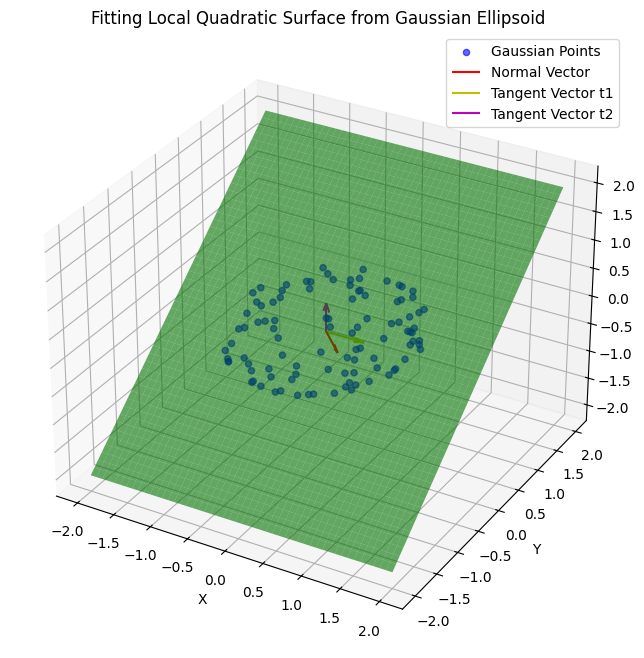

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import eigh
from scipy.optimize import least_squares

# 生成3D高斯椭球
def generate_gaussian_ellipsoid(center, cov_matrix, num_points=100):
    eigvals, eigvecs = eigh(cov_matrix)
    eigvals = np.sqrt(eigvals)
    
    points = np.random.randn(num_points, 3)
    points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]  # 单位化
    points = points @ np.diag(eigvals) @ eigvecs.T  # 扩展为椭球形状
    points += center  # 加上中心位置
    return points

# 二次曲面拟合模型函数
def quadratic_surface(params, X, Y):
    # 参数为 A, B, C, D, E, F
    A, B, C, D, E, F = params
    return A * X**2 + B * X * Y + C * Y**2 + D * X + E * Y + F

# 残差函数（用于最小二乘法）
def residuals(params, X, Y, Z):
    return quadratic_surface(params, X, Y) - Z

# 计算法向量（最小特征值对应的特征向量）
def compute_normal(cov_matrix):
    eigvals, eigvecs = eigh(cov_matrix)
    normal = eigvecs[:, np.argmin(eigvals)]  # 最小特征值对应的特征向量
    return normal

# 提取局部切平面和拟合二次曲面
def fit_local_quadratic_surface(points, p_i, cov_matrix):
    # 计算局部法向量
    normal = compute_normal(cov_matrix)
    
    # 选择邻域内的点进行拟合
    distances = np.linalg.norm(points - p_i, axis=1)
    nearest_points_idx = np.argsort(distances)[:10]
    nearest_points = points[nearest_points_idx]
    
    # 计算切平面上的坐标
    t1 = np.array([1, 0, 0])  # 简单地选择一个方向
    t2 = np.cross(normal, t1)  # 使用法向量的叉积来计算第二个切向量
    t2 = t2 / np.linalg.norm(t2)  # 规范化
    
    # 计算相对坐标并投影到切平面
    u = (nearest_points - p_i) @ np.array([t1, t2]).T
    
    X = u[:, 0]
    Y = u[:, 1]
    Z = nearest_points[:, 2]
    
    # 使用最小二乘法拟合二次曲面
    initial_params = np.zeros(6)  # 初始猜测参数 (A, B, C, D, E, F)
    result = least_squares(residuals, initial_params, args=(X, Y, Z))
    
    return result.x, normal, t1, t2  # 返回拟合参数和切平面信息

# 可视化拟合过程
def visualize_fitting_process(points, p_i, cov_matrix, params, normal, t1, t2):
    # 绘制拟合后的二次曲面
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 绘制高斯椭球的点
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b', label='Gaussian Points', alpha=0.6)

    # 网格化X, Y坐标
    x = np.linspace(-2, 2, 50)
    y = np.linspace(-2, 2, 50)
    x, y = np.meshgrid(x, y)

    # 计算拟合的Z值
    z = quadratic_surface(params, x, y)

    # 绘制拟合的二次曲面
    ax.plot_surface(x, y, z, color='g', alpha=0.6)

    # 绘制局部切平面
    ax.quiver(p_i[0], p_i[1], p_i[2], normal[0], normal[1], normal[2], length=0.5, color='r', label='Normal Vector')
    ax.quiver(p_i[0], p_i[1], p_i[2], t1[0], t1[1], t1[2], length=0.5, color='y', label='Tangent Vector t1')
    ax.quiver(p_i[0], p_i[1], p_i[2], t2[0], t2[1], t2[2], length=0.5, color='m', label='Tangent Vector t2')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Fitting Local Quadratic Surface from Gaussian Ellipsoid')

    ax.legend()
    plt.show()

# 生成高斯椭球及拟合
center = np.array([0, 0, 0])
cov_matrix = np.array([[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]])  # 协方差矩阵
points = generate_gaussian_ellipsoid(center, cov_matrix)

p_i = center  # 高斯分布中心

# 拟合局部二次曲面
params, normal, t1, t2 = fit_local_quadratic_surface(points, p_i, cov_matrix)

# 可视化拟合过程
visualize_fitting_process(points, p_i, cov_matrix, params, normal, t1, t2)


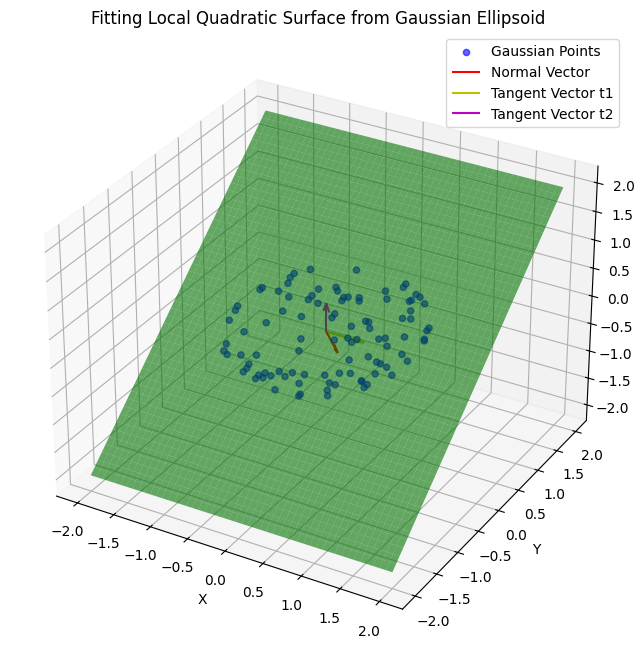

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import eigh
from scipy.optimize import least_squares

# 生成3D高斯椭球
def generate_gaussian_ellipsoid(center, cov_matrix, num_points=100):
    eigvals, eigvecs = eigh(cov_matrix)
    eigvals = np.sqrt(eigvals)
    
    points = np.random.randn(num_points, 3)
    points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]  # 单位化
    points = points @ np.diag(eigvals) @ eigvecs.T  # 扩展为椭球形状
    points += center  # 加上中心位置
    return points

# 二次曲面拟合模型函数
def quadratic_surface(params, X, Y):
    A, B, C, D, E, F = params
    return A * X**2 + B * X * Y + C * Y**2 + D * X + E * Y + F

# 残差函数（用于最小二乘法）
def residuals(params, X, Y, Z):
    return quadratic_surface(params, X, Y) - Z

# 计算法向量（最小特征值对应的特征向量）
def compute_normal(cov_matrix):
    eigvals, eigvecs = eigh(cov_matrix)
    normal = eigvecs[:, np.argmin(eigvals)]  # 最小特征值对应的特征向量
    return normal

# 提取局部切平面和拟合二次曲面
def fit_local_quadratic_surface(points, p_i, cov_matrix):
    normal = compute_normal(cov_matrix)
    
    # 选择邻域内的点进行拟合
    distances = np.linalg.norm(points - p_i, axis=1)
    nearest_points_idx = np.argsort(distances)[:20]  # 使用更多的邻近点
    nearest_points = points[nearest_points_idx]
    
    # 计算切平面上的坐标
    t1 = np.array([1, 0, 0])  # 简单地选择一个方向
    t2 = np.cross(normal, t1)  # 使用法向量的叉积来计算第二个切向量
    t2 = t2 / np.linalg.norm(t2)  # 规范化
    
    # 计算相对坐标并投影到切平面
    u = (nearest_points - p_i) @ np.array([t1, t2]).T
    
    X = u[:, 0]
    Y = u[:, 1]
    Z = nearest_points[:, 2]
    
    # 使用最小二乘法拟合二次曲面
    initial_params = np.zeros(6)  # 初始猜测参数 (A, B, C, D, E, F)
    result = least_squares(residuals, initial_params, args=(X, Y, Z))
    
    return result.x, normal, t1, t2  # 返回拟合参数和切平面信息

# 可视化拟合过程
def visualize_fitting_process(points, p_i, cov_matrix, params, normal, t1, t2):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 绘制高斯椭球的点
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b', label='Gaussian Points', alpha=0.6)

    # 网格化X, Y坐标
    x = np.linspace(-2, 2, 50)
    y = np.linspace(-2, 2, 50)
    x, y = np.meshgrid(x, y)

    # 计算拟合的Z值
    z = quadratic_surface(params, x, y)

    # 绘制拟合的二次曲面
    ax.plot_surface(x, y, z, color='g', alpha=0.6)

    # 绘制局部切平面
    ax.quiver(p_i[0], p_i[1], p_i[2], normal[0], normal[1], normal[2], length=0.5, color='r', label='Normal Vector')
    ax.quiver(p_i[0], p_i[1], p_i[2], t1[0], t1[1], t1[2], length=0.5, color='y', label='Tangent Vector t1')
    ax.quiver(p_i[0], p_i[1], p_i[2], t2[0], t2[1], t2[2], length=0.5, color='m', label='Tangent Vector t2')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Fitting Local Quadratic Surface from Gaussian Ellipsoid')

    ax.legend()
    
    # 设置交互旋转
    plt.ion()  # 开启交互模式
    plt.show()

# 生成高斯椭球及拟合
center = np.array([0, 0, 0])
cov_matrix = np.array([[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]])  # 协方差矩阵
points = generate_gaussian_ellipsoid(center, cov_matrix)

p_i = center  # 高斯分布中心

# 拟合局部二次曲面
params, normal, t1, t2 = fit_local_quadratic_surface(points, p_i, cov_matrix)

# 可视化拟合过程
visualize_fitting_process(points, p_i, cov_matrix, params, normal, t1, t2)
